In [8]:
# define a model using pytorch
# a pretrained model adding layers to classify the 4 classes of the images
import torch.nn as nn
from torchvision import models
from torchvision.models import squeezenet1_1
from torchvision.models.squeezenet import SqueezeNet1_1_Weights


class MIDmodel(nn.Module):
    def __init__(self):
        super(MIDmodel, self).__init__()
        self.pretrained = squeezenet1_1(pretrained=True)
        self.fc1 = nn.Linear(1000, 128)
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, root_dir, patients_ids, patients_df, transform=None):
        self.patients_df = patients_df[patients_df["patient_id"].isin(patients_ids)]
        self.root_dir = root_dir
        self.idxs = set()
        if transform:
            self.transform = transform
        else:
            self.transform = None
               
            
    def __len__(self):
        return len(self.patients_df)

    def __getitem__(self, idx):
        row = self.patients_df.iloc[idx]
        # path = root_dir/patientid_examid_spot_framenumber_score.png
        path = os.path.join(self.root_dir, row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")
        image = Image.open(path)
        label = row["score"]

        if self.transform:
            image = self.transform(image)
        # in any case, transform to tensor
        image = transforms.ToTensor()(image)
        # image = transforms.Normalize(mean = [17.29368658, 15.58648964, 15.50668094], std = [32.30078458, 28.69238728, 28.48813082])(image)
        # image = image / 255.0
        image = transforms.Resize((224, 224))(image)
        # Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        # rescale the image to [0.0, 1.0]
        
        #image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        return image, int(label), path

In [ ]:
import pandas as pd
import torch
import glob
data_dir = "images/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images_paths = glob.glob(f"{data_dir}*.png", recursive=True)
# images are named as: patientid_examid_spotnumber_framenumber_score.png
# create a dataframe with the data removing "images/"
images_df = pd.DataFrame([path[len(data_dir):-4].split("_") for path in images_paths], columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
images_df["score"] = images_df["score"].astype(str)
images_df["frame_number"] = images_df["frame_number"].astype(str)
images_df["spot"] = images_df["spot"].astype(str)
images_df["patient_id"] = images_df["patient_id"].astype(str)
images_df["exam_id"] = images_df["exam_id"].astype(str)
patients_ids = set(images_df["patient_id"])
patients_ids = list(patients_ids)

# select the 8 patients for training based on the most balanced distribution of the scores
import itertools
combs = list(itertools.combinations(patients_ids, 8))
stds = []
for i, c in enumerate(combs):
    stds.append((images_df[images_df["patient_id"].isin(c)].groupby("score").count()["patient_id"].std(), i))

train_patients = [x for x in combs[min(stds)[1]]]
print(train_patients)
print(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"])
test_patients = [x for x in patients_ids if x not in train_patients]
print(test_patients)
print(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"])


['1069', '1050', '1067', '1052', '1017', '1048', '1047', '1051']
score
0    7888
1    7540
2    7189
3    7592
Name: patient_id, dtype: int64
['1045', '1066', '1068']
score
0    6625
1    1721
2    5535
3    3631
Name: patient_id, dtype: int64


transformations from the paper Deep Learning for Classification and Localization of COVID-19 Markers in Point-of-Care Lung Ultrasound
were each activated on the image-label pair with a probability of 0.33. The set of augmentation functions, each applied with a randomly sampled strength bounded by a set maximum, consists of:
- affine transformations (translation (max. ±15%), rotation (max. ±15◦), scaling (max. ±45%), and shearing (max. ±4.5◦))
- multiplication with a constant (max. ±45%)
- Gaussian blurring (σmax = 3/4 )
- contrast distortion (max. ±45%)
- horizontal flipping (p = 0.5)
- additive white Gaussian noise (σmax = 0.015)

In [ ]:
transformations = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0, 0.15), scale=(0.55, 1.45), shear=4.5)], p=1/3),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.45, contrast=0.45, saturation=0.45, hue=0.45)], p=1/3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.75))], p=1/3),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=1/3),
    ])

In [ ]:
from torch import optim
from tqdm import tqdm

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels, _ in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects/ len(dataloader.dataset)
    return epoch_loss, epoch_acc

def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [ ]:
data_dir = "images/"
num_epochs = 20
# 18 minutes per epoch, 6 hours for 20 epochs
learning_rate = 0.00001
batch_size = 8

model = MIDmodel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_dataset = ImageDataset(data_dir, train_patients, images_df, transformations)
# for the patients in the test set, se create a new image_df with 1000 images per class
test_images_df = images_df[images_df["patient_id"].isin(test_patients)]
test_images_df = test_images_df.groupby("score").apply(lambda x: x.sample(1000)).reset_index(drop=True)
test_dataset = ImageDataset(data_dir, test_patients, test_images_df)

# test_dataset = ImageDataset(data_dir, test_patients, images_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
results_train = []
results_test = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    results_train.append([train_loss, train_acc])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
    results_test.append([test_loss, test_acc])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    #if epoch % 5 == 0:
    torch.save(model.state_dict(), f"MIDmodel_{epoch}.pt")
    if epoch % 2 == 1:
        learning_rate = learning_rate/2
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# save the model
torch.save(model.state_dict(), f"MIDmodel.pt")

Epoch 0


100%|██████████| 3777/3777 [16:06<00:00,  3.91it/s]


Training Loss: 1.4461 Training Accuracy: 0.2549


100%|██████████| 500/500 [00:55<00:00,  9.06it/s]


Test Loss: 1.3819 Test Accuracy: 0.2503
Epoch 1


100%|██████████| 3777/3777 [16:56<00:00,  3.72it/s]


Training Loss: 1.3344 Training Accuracy: 0.2986


100%|██████████| 500/500 [00:55<00:00,  8.98it/s]


Test Loss: 1.3551 Test Accuracy: 0.3080
Epoch 2


100%|██████████| 3777/3777 [16:55<00:00,  3.72it/s]


Training Loss: 1.2288 Training Accuracy: 0.3777


100%|██████████| 500/500 [00:55<00:00,  8.98it/s]


Test Loss: 1.3453 Test Accuracy: 0.4510
Epoch 3


100%|██████████| 3777/3777 [25:02<00:00,  2.51it/s]


Training Loss: 1.1488 Training Accuracy: 0.4601


100%|██████████| 500/500 [01:19<00:00,  6.29it/s]


Test Loss: 1.2667 Test Accuracy: 0.3718
Epoch 4


100%|██████████| 3777/3777 [17:45<00:00,  3.55it/s]


Training Loss: 1.0441 Training Accuracy: 0.5171


100%|██████████| 500/500 [00:56<00:00,  8.90it/s]


Test Loss: 1.2601 Test Accuracy: 0.3830
Epoch 5


100%|██████████| 3777/3777 [20:15<00:00,  3.11it/s] 


Training Loss: 1.0109 Training Accuracy: 0.5305


100%|██████████| 500/500 [00:58<00:00,  8.56it/s]


Test Loss: 1.2308 Test Accuracy: 0.4333
Epoch 6


100%|██████████| 3777/3777 [17:04<00:00,  3.69it/s]


Training Loss: 0.9817 Training Accuracy: 0.5514


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


Test Loss: 1.2265 Test Accuracy: 0.4298
Epoch 7


100%|██████████| 3777/3777 [16:34<00:00,  3.80it/s]


Training Loss: 0.9709 Training Accuracy: 0.5589


100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


Test Loss: 1.2509 Test Accuracy: 0.4025
Epoch 8


100%|██████████| 3777/3777 [16:40<00:00,  3.78it/s]


Training Loss: 0.9603 Training Accuracy: 0.5611


100%|██████████| 500/500 [00:59<00:00,  8.36it/s]


Test Loss: 1.2337 Test Accuracy: 0.4188
Epoch 9


100%|██████████| 3777/3777 [16:31<00:00,  3.81it/s]


Training Loss: 0.9523 Training Accuracy: 0.5683


100%|██████████| 500/500 [00:59<00:00,  8.39it/s]


Test Loss: 1.2413 Test Accuracy: 0.4203
Epoch 10


100%|██████████| 3777/3777 [16:35<00:00,  3.79it/s]


Training Loss: 0.9460 Training Accuracy: 0.5683


100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


Test Loss: 1.2480 Test Accuracy: 0.4165
Epoch 11


100%|██████████| 3777/3777 [16:47<00:00,  3.75it/s]


Training Loss: 0.9465 Training Accuracy: 0.5721


100%|██████████| 500/500 [00:54<00:00,  9.20it/s]


Test Loss: 1.2358 Test Accuracy: 0.4245
Epoch 12


100%|██████████| 3777/3777 [16:29<00:00,  3.82it/s]


Training Loss: 0.9472 Training Accuracy: 0.5726


100%|██████████| 500/500 [01:01<00:00,  8.14it/s]


Test Loss: 1.2483 Test Accuracy: 0.4133
Epoch 13


100%|██████████| 3777/3777 [17:10<00:00,  3.67it/s]


Training Loss: 0.9447 Training Accuracy: 0.5754


100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


Test Loss: 1.2542 Test Accuracy: 0.4140
Epoch 14


100%|██████████| 3777/3777 [17:25<00:00,  3.61it/s]


Training Loss: 0.9368 Training Accuracy: 0.5792


100%|██████████| 500/500 [01:00<00:00,  8.26it/s]


Test Loss: 1.2591 Test Accuracy: 0.4120
Epoch 15


100%|██████████| 3777/3777 [17:24<00:00,  3.61it/s]


Training Loss: 0.9429 Training Accuracy: 0.5730


100%|██████████| 500/500 [01:01<00:00,  8.17it/s]


Test Loss: 1.2540 Test Accuracy: 0.4143
Epoch 16


100%|██████████| 3777/3777 [16:33<00:00,  3.80it/s]


Training Loss: 0.9376 Training Accuracy: 0.5793


100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


Test Loss: 1.2544 Test Accuracy: 0.4143
Epoch 17


100%|██████████| 3777/3777 [18:46<00:00,  3.35it/s]


Training Loss: 0.9381 Training Accuracy: 0.5766


100%|██████████| 500/500 [01:18<00:00,  6.40it/s]


Test Loss: 1.2545 Test Accuracy: 0.4175
Epoch 18


100%|██████████| 3777/3777 [25:18<00:00,  2.49it/s]


Training Loss: 0.9403 Training Accuracy: 0.5768


100%|██████████| 500/500 [00:54<00:00,  9.11it/s]


Test Loss: 1.2536 Test Accuracy: 0.4178
Epoch 19


100%|██████████| 3777/3777 [16:12<00:00,  3.88it/s]


Training Loss: 0.9387 Training Accuracy: 0.5758


100%|██████████| 500/500 [00:55<00:00,  9.05it/s]


Test Loss: 1.2555 Test Accuracy: 0.4140


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

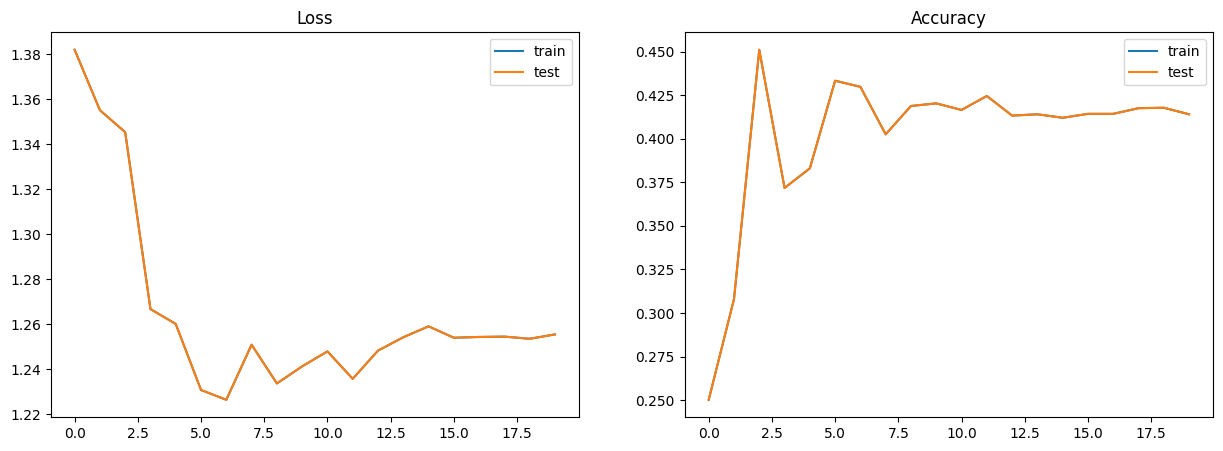

In [ ]:
# subplots with results
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(results_train)[:, 0], label="train")
ax[0].plot(np.array(results_test)[:, 0], label="test")
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(np.array(results_train)[:, 1], label="train")
ax[1].plot(np.array(results_test)[:, 1], label="test")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2189/2189 [04:00<00:00,  9.12it/s]


Test Loss: 1.5062 Test Accuracy: 0.4978


100%|██████████| 2189/2189 [03:46<00:00,  9.64it/s]


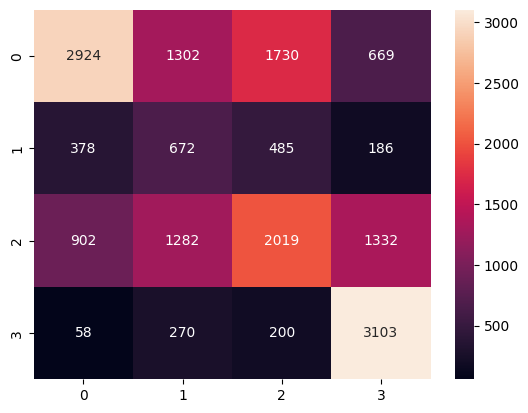

In [ ]:
# load the MIDmodel_old
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel_old.pt"))
model = model.to(device)
# test the model on the test set
test_dataset = ImageDataset(data_dir, test_patients, images_df)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# create the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()



Classifier to predict if the confidence is high enough, created on the train dataset

In [ ]:
# load the last model
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel_old.pt"))
model.to(device)
model.eval()

correct_preds = pd.DataFrame(columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])
wrong_preds = pd.DataFrame(columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])

for i in tqdm(range(len(test_dataset))):
    img, label, path = test_dataset[i]
    img = img.unsqueeze(0)
    img = img.to(device)
    output = model(img)
    sm = nn.Softmax(dim=1)
    sm = sm(output)
    sm = sm.cpu().detach().numpy()
    sm = sm[0]
    if torch.argmax(output) == label:
        correct_preds = pd.concat([correct_preds, pd.DataFrame([[path, label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])])
    else:
        wrong_preds = pd.concat([wrong_preds, pd.DataFrame([[path, label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])])

correct_preds.to_csv("correct_preds_test.csv", index=False)
wrong_preds.to_csv("wrong_preds_test.csv", index=False)


c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 17512/17512 [05:38<00:00, 51.80it/s]


In [ ]:
correct_preds = pd.read_csv("correct_preds_test.csv")
wrong_preds = pd.read_csv("wrong_preds_test.csv")

# add a clumn to correct_preds and wrong_preds that says if it's correct or not
correct_preds["correct"] = 1
wrong_preds["correct"] = 0
# stack the two dataframes
preds_total = pd.concat([correct_preds, wrong_preds])
# remove true and predicted columns
# preds_total = preds_total.drop(["true", "predicted"], axis=1)
# save the values
preds_total.to_csv("values_test.csv", index=False)

DL model to binary classify images

In [ ]:

class MIDbinary(nn.Module):
    def __init__(self):
        super(MIDbinary, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc4 = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x
    
# BinaryDataset
class BinaryDataset(Dataset):
    def __init__(self, preds):
        self.preds = preds

    def __len__(self):
        return len(self.preds)

    def __getitem__(self, idx):
        label = self.preds.iloc[idx]["correct"]
        sms = self.preds.iloc[idx][["sm0", "sm1", "sm2", "sm3"]]
        sms = torch.tensor(list(sms.values), dtype=torch.float32)
        return sms, int(label), self.preds.iloc[idx]["path"]

In [ ]:
import matplotlib.pyplot as plt

# train the binary model
binary_model = MIDbinary()
binary_model = binary_model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)

train_values = pd.read_csv("values_train.csv")
test_values = pd.read_csv("values_test.csv")

train_dataset_bin = BinaryDataset(train_values)
test_dataset_bin = BinaryDataset(test_values)
train_dataloader_bin = DataLoader(train_dataset_bin, batch_size=batch_size, shuffle=True)
test_dataloader_bin = DataLoader(test_dataset_bin, batch_size=batch_size, shuffle=True)

results_train = []
results_test = []
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(binary_model, train_dataloader_bin, optimizer, criterion, device)
    results_train.append([train_loss, train_acc.item()])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(binary_model, test_dataloader_bin, criterion, device)
    results_test.append([test_loss, test_acc.item()])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if( epoch > 0  and (results_train[len(results_train)-1][0] >=  results_train[len(results_train)-2][0])):
        print(results_train[len(results_train)-1], results_train[len(results_train)-2])
        print("Overfitting")
        break
    if epoch % 2 == 0:
        learning_rate = learning_rate/2
        optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)

print("Train: ", results_train)
print("Test: ", results_test)

# subplots with train[0], train[1], test[0], test[1]
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot([i[0] for i in results_train])
axs[0, 0].set_title("Train Loss")
axs[0, 1].plot([i[1] for i in results_train])
axs[0, 1].set_title("Train Accuracy")
axs[1, 0].plot([i[0] for i in results_test])
axs[1, 0].set_title("Test Loss")
axs[1, 1].plot([i[1] for i in results_test])
axs[1, 1].set_title("Test Accuracy")
plt.show()

Epoch 0


100%|██████████| 3777/3777 [00:18<00:00, 201.68it/s]


Training Loss: 0.7014 Training Accuracy: 0.3516


100%|██████████| 2189/2189 [00:09<00:00, 237.80it/s]


Test Loss: 0.6958 Test Accuracy: 0.4181
Epoch 1


100%|██████████| 3777/3777 [00:18<00:00, 205.37it/s]


Training Loss: 0.6800 Training Accuracy: 0.7852


100%|██████████| 2189/2189 [00:09<00:00, 231.36it/s]


Test Loss: 0.6961 Test Accuracy: 0.4978
Epoch 2


100%|██████████| 3777/3777 [00:18<00:00, 206.96it/s]


Training Loss: 0.6675 Training Accuracy: 0.8108


100%|██████████| 2189/2189 [00:09<00:00, 232.75it/s]


Test Loss: 0.6968 Test Accuracy: 0.4978
Epoch 3


100%|██████████| 3777/3777 [00:18<00:00, 208.43it/s]


Training Loss: 0.6588 Training Accuracy: 0.8108


100%|██████████| 2189/2189 [00:09<00:00, 238.22it/s]


Test Loss: 0.6973 Test Accuracy: 0.4978
Epoch 4


100%|██████████| 3777/3777 [00:18<00:00, 206.09it/s]


Training Loss: 0.6534 Training Accuracy: 0.8108


100%|██████████| 2189/2189 [00:09<00:00, 232.28it/s]


Test Loss: 0.6978 Test Accuracy: 0.4978
Epoch 5


 25%|██▍       | 935/3777 [00:04<00:13, 205.11it/s]


KeyboardInterrupt: 

In [ ]:
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel_old.pt"))
model.to(device)
model.eval()

# get the predictions for the test set and pass it to the binary model
usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label, _ = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    # print(sm)
    binary_output = binary_model(sm)
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = torch.argmax(binary_output).cpu().detach().numpy()
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1

print("Usefulness of the binary model (test set):")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)

c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 17512/17512 [04:25<00:00, 65.92it/s]

Usefulness of the binary model (test set):
Useful:  8718
Useful[%]:  49.78300593878483
Useless:  8794
Useless[%]:  50.21699406121517


In [ ]:
# simple binary classificator with svc
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# load the values
pred_train = pd.read_csv("values_train.csv")
pred_test = pd.read_csv("values_test.csv")

# X_train, X_test, y_train, y_test = train_test_split(preds_total.drop("correct", axis=1), preds_total["correct"], test_size=0.2)
pred_train = pred_train.drop("path", axis=1)
pred_test = pred_test.drop("path", axis=1)
pred_train = pred_train.drop("true", axis=1)
pred_test = pred_test.drop("true", axis=1)
pred_test = pred_test.drop("predicted", axis=1)
pred_train = pred_train.drop("predicted", axis=1)

# we need preds_train and preds_test to have 50% of correct = 1 and 50% of correct = 0, but the dataset is not balanced
# so we need to balance it
print("Train correct = 1: ", len(pred_train[pred_train["correct"] == 1]))
print("Train correct = 0: ", len(pred_train[pred_train["correct"] == 0]))
print("Test correct = 1: ", len(pred_test[pred_test["correct"] == 1]))
print("Test correct = 0: ", len(pred_test[pred_test["correct"] == 0]))
preds_tmp = pred_train[pred_train["correct"] == 0]
preds_tmp = preds_tmp.append(pred_train[pred_train["correct"] == 1][:len(preds_tmp)])
pred_train = preds_tmp
print("Train correct = 1: ", len(pred_train[pred_train["correct"] == 1]))
print("Train correct = 0: ", len(pred_train[pred_train["correct"] == 0]))


X_train = pred_train.drop("correct", axis=1)
y_train = pred_train["correct"]
X_test = pred_test.drop("correct", axis=1)
y_test = pred_test["correct"]
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
# save clf to file
import pickle
pickle.dump(clf, open("svc.pkl", "wb"))


Train correct = 1:  24493
Train correct = 0:  5716
Test correct = 1:  8718
Test correct = 0:  8794
Train correct = 1:  5716
Train correct = 0:  5716


C:\Users\Davide\AppData\Local\Temp\ipykernel_17104\516717542.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preds_tmp = preds_tmp.append(pred_train[pred_train["correct"] == 1][:len(preds_tmp)])


Accuracy:  0.6337368661489264


In [ ]:
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel_old.pt"))
model.to(device)
model.eval()
# read svc model from file
clf = pickle.load(open("svc.pkl", 'rb'))
entire_dataset = ImageDataset(data_dir, patients_ids, images_df)

# get the predictions for the test set and pass it to the binary model
usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label, paths = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    sm =sm.cpu().detach().numpy()
    binary_output = clf.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = binary_output[0]
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1


print("Usefulness of the SVC (test set):")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)
    


c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 17512/17512 [05:06<00:00, 57.19it/s]

Usefulness of the SVC (test set):
Useful:  11098
Useful[%]:  63.37368661489264
Useless:  6414
Useless[%]:  36.62631338510736


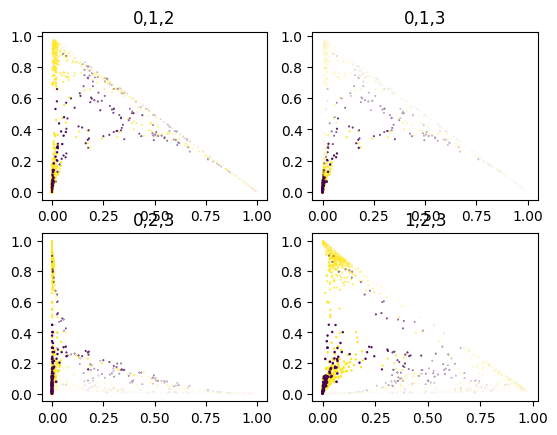

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# read the csv file with the values
values = pd.read_csv("values.csv") #sm0, sm1, sm2, sm3, correct 
points = values[["sm0", "sm1", "sm2", "sm3"]].values
# plot the points in 4 3D plots with 0,1,2; 0,1,3; 0,2,3; 1,2,3
fig, axs = plt.subplots(2, 2)
#3D plot with 0,1,2
axs[0, 0].scatter(points[:,0], points[:,1], points[:,2], c=values["correct"])
axs[0, 0].set_title("0,1,2")
#3D plot with 0,1,3
axs[0, 1].scatter(points[:,0], points[:,1], points[:,3], c=values["correct"])
axs[0, 1].set_title("0,1,3")
#3D plot with 0,2,3
axs[1, 0].scatter(points[:,0], points[:,2], points[:,3], c=values["correct"])
axs[1, 0].set_title("0,2,3")
#3D plot with 1,2,3
axs[1, 1].scatter(points[:,1], points[:,2], points[:,3], c=values["correct"])
axs[1, 1].set_title("1,2,3")
plt.show()

t-SNE to visualize only the correct prediction (but still in both train and test)

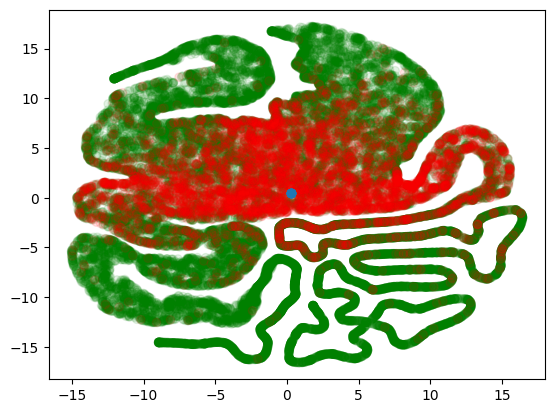

True label:  0
Predicted label:  1


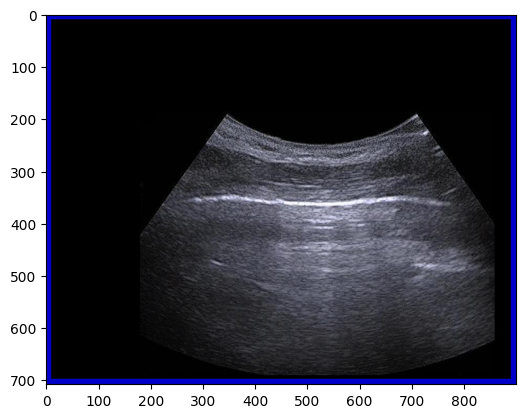

True label:  0
Predicted label:  1


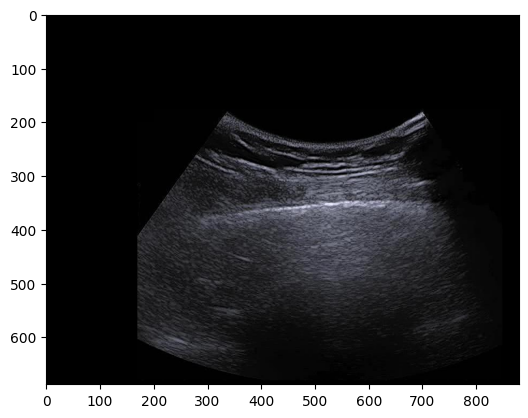

True label:  1
Predicted label:  1


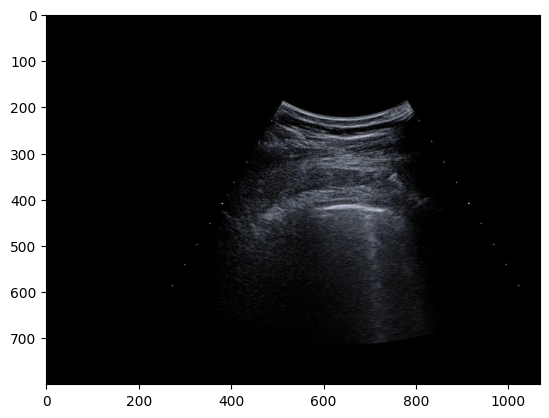

True label:  2
Predicted label:  1


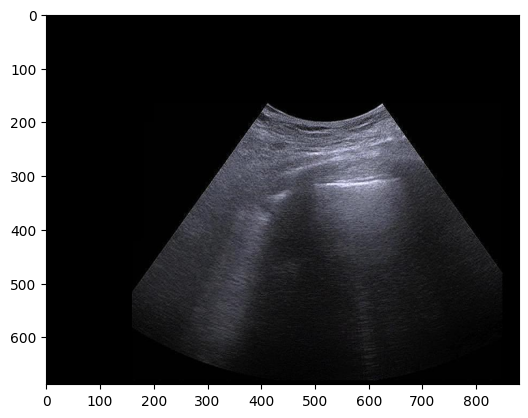

True label:  1
Predicted label:  1


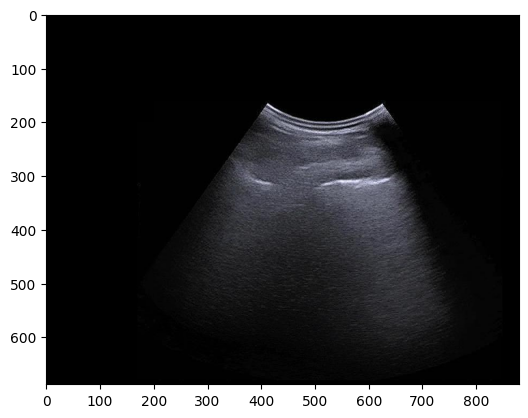

True label:  2
Predicted label:  1


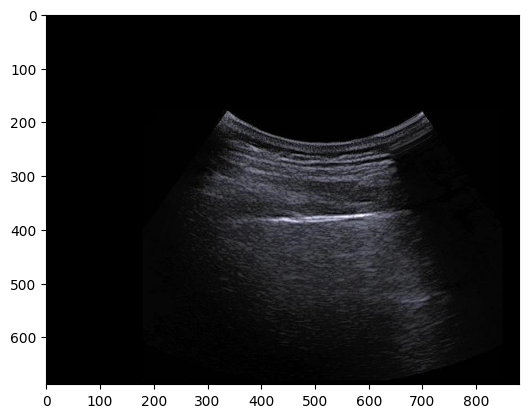

In [12]:
# TODO: using the "path" stored in the csv file, plot the TSNE of the training set and for a random point of the test set retrieve the nearest 3 images and plot them
# import TNSE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

# create the TNSE model (keeping the path information for later)
values = pd.read_csv("values_train.csv") #sm0, sm1, sm2, sm3, correct
points = values[["sm0", "sm1", "sm2", "sm3"]].values
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(points)
values["x"] = tsne_results[:,0]
values["y"] = tsne_results[:,1]
# plot the points
colors = ["green" if int(c) == 1 else "red" for c in values["correct"]]
plt.scatter(values["x"], values["y"], c=colors, alpha=0.1)
# plt.show()

# plot the nearest 3 images for a random point of the test set
# get the random point
test_values = pd.read_csv("values_test.csv") #sm0, sm1, sm2, sm3, correct
test_points = test_values[["sm0", "sm1", "sm2", "sm3"]].values
random_index = np.random.randint(0, len(test_points))
selected_point = test_points[random_index]
# get the nearest 3 points
distances = np.linalg.norm(points - selected_point, axis=1)
nearest_points = points[np.argsort(distances)[:5]]
# plot the nearest 3 points
# plt.scatter(values["x"], values["y"], c=values["correct"])
plt.scatter(nearest_points[:,0], nearest_points[:,1])
plt.show()

# print true and predicted label of the selected_point
print("True label: ", test_values.iloc[random_index]["true"])
print("Predicted label: ", test_values.iloc[random_index]["predicted"])
# print the selected point image with a red circle
image = cv2.imread(test_values.iloc[random_index]["path"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# add the border
image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 200])

plt.imshow(image)
plt.show()
# show the images
# get the paths of the nearest 3 points
nearest_points_paths = values.iloc[np.argsort(distances)[:5]]["path"].values
# plot the images
for path in nearest_points_paths:
    # print also the true and predicted label
    print("True label: ", values[values["path"] == path]["true"].values[0])
    print("Predicted label: ", values[values["path"] == path]["predicted"].values[0])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()




In [ ]:
# near-duplicate image search with Locality Sensitive Hashing
# https://keras.io/examples/vision/near_dup_search/
